## Import des librairies et chargement de la data

In [10]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


data = pd.read_csv('dev.txt', sep='\t')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Prétraitement

In [11]:

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Supprimer les stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

data['Tweet_Preprocessed'] = data['Tweet'].apply(preprocess_text)


## Enregistrement des données

In [12]:
data_preprocessed = data[['Tweet_Preprocessed', 'Intensity Class']]

data_preprocessed.to_csv('preprocessed_data2.csv', index=False)

print(data_preprocessed.head(5))


                                  Tweet_Preprocessed  \
0  ryanair site crash everytime try book help tel...   
1  theme week ask lord strength amp perspective p...   
2  f announcing late hard make manchester organis...   
3  greatest happiness seeing someone like stay ha...   
4  omg grateful education ive back school two day...   

                                     Intensity Class  
0  -3: very negative emotional state can be inferred  
1  -2: moderately negative emotional state can be...  
2  -3: very negative emotional state can be inferred  
3   3: very positive emotional state can be inferred  
4  1: slightly positive emotional state can be in...  


## Spliter la data

In [13]:

data = pd.read_csv('preprocessed_data2.csv')

X = data['Tweet_Preprocessed']
y = pd.get_dummies(data['Intensity Class'])  # Convertir les labels en one-hot encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Tokenisation et vectorisation

In [14]:
# Tokenisation et vectorisation des données
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding pour avoir des séquences de longueur égale
max_len = 34  
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)


## Chargement et évaluation du modèle

In [15]:
# Charger le modèle LSTM pré-entraîné
pretrained_model = load_model('emotion_classification_model.keras')

# Geler les couches inférieures pour éviter l'entraînement
for layer in pretrained_model.layers:
    layer.trainable = False

# Ajouter de nouvelles couches au-dessus des couches pré-entraînées
new_model = Sequential()
new_model.add(pretrained_model)
new_model.add(Dense(64, activation='relu'))  
new_model.add(Dense(7, activation='softmax')) 

new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

new_model.fit(X_train, y_train, batch_size=32, epochs=12, validation_data=(X_test, y_test))

# Évaluation du modèle
loss,accuracy = new_model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)


Epoch 1/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.0900 - loss: 1.9783 - val_accuracy: 0.1667 - val_loss: 1.9415
Epoch 2/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1466 - loss: 1.9424 - val_accuracy: 0.2000 - val_loss: 1.9289
Epoch 3/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1471 - loss: 1.9189 - val_accuracy: 0.1444 - val_loss: 1.9217
Epoch 4/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2389 - loss: 1.9098 - val_accuracy: 0.1333 - val_loss: 1.9193
Epoch 5/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2534 - loss: 1.8867 - val_accuracy: 0.1222 - val_loss: 1.9193
Epoch 6/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2549 - loss: 1.8741 - val_accuracy: 0.1111 - val_loss: 1.9216
Epoch 7/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2446 - loss: 1.8828 - val_accuracy: 0.1111 - val_loss: 1.9259
Epoch 8/12
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2527 - loss: 1.8426 - val_accuracy: 0.1111 - 

## Prédiction sur des données test

In [16]:
with open('data_test.txt', 'r', encoding='utf-8') as file:
    data_test = file.readlines()[1:]

# Prétraitement des données de test
X_test = tokenizer.texts_to_sequences(data_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

# Faire des prédictions sur les données de test
predictions = new_model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

np.savetxt('predictions.txt', predicted_classes, fmt='%d')


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
[3 3 3 ... 3 1 3]


## Partie évaluation 

In [17]:
y_true = [int(line.split('\t')[-1].split(':')[0].split()[0]) for line in lines]
with open('data_test.txt', 'r', encoding='utf-8') as file:
     lines = file.readlines()[1:]  # Exclure la première ligne

accuracy = accuracy_score(y_true, predicted_classes)

print("Accuracy:", accuracy)

pearson_corr, _ = pearsonr(y_true, predicted_classes)
print("Pearson correlation coefficient:", pearson_corr)

weighted_kappa = cohen_kappa_score(y_true, predicted_classes, weights='quadratic')
print("Weighted quadratic kappa:", weighted_kappa)


Accuracy: 0.0624385447394297
Pearson correlation coefficient: -0.13441874017251088
Weighted quadratic kappa: -0.03885772114832875


## Partie visualisation données test

C:\Users\a\AppData\Local\Temp\ipykernel_3492\1782786601.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_true, data=data_test, palette="viridis")


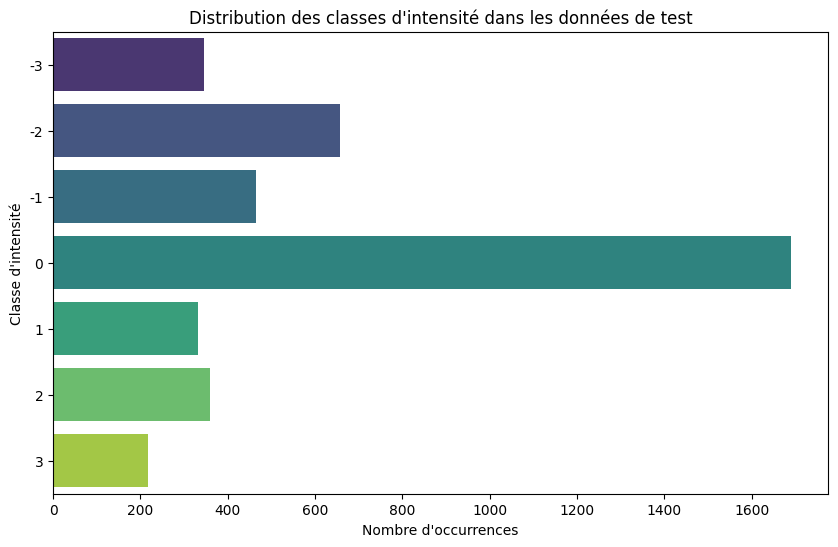

In [18]:
data_test = pd.read_csv('data_test.txt', delimiter='\t')

y_true = [int(line.split('\t')[-1].split(':')[0].split()[0]) for line in lines]

plt.figure(figsize=(10, 6))
sns.countplot(y=y_true, data=data_test, palette="viridis")
plt.title("Distribution des classes d'intensité dans les données de test")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Classe d'intensité")
plt.show()